# import stuff

In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import glob
import netCDF4
import pandas
import wrf
import string
import seaborn
import matplotlib.colors
import cmocean
import matplotlib.cm

import metpy
import metpy.plots
import metpy.calc
import metpy.units

import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

# set up wet and dry regions

In [2]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [3]:
lon_lo_ama = dry_lon_lo
lon_hi_ama = dry_lon_hi
lat_lo_ama = dry_lat_lo
lat_hi_ama = dry_lat_hi

lon_lo_and = wet_lon_lo
lon_hi_and = wet_lon_hi
lat_lo_and = wet_lat_lo
lat_hi_and = wet_lat_hi

# open control data

In [4]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [5]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [6]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [7]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [8]:
hgt = cont_mfds['HGT'].sel(Time=0).values

# get time info

In [9]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')

In [10]:
time_datetimes_shifted_ama = time_datetimes + datetime.timedelta(hours=-4)
time_datetimes_shifted_and = time_datetimes + datetime.timedelta(hours=-5)

# get land mask info

In [11]:
landmask_indices = numpy.copy(landmask)
landmask_indices[landmask==1]=1
landmask_indices[landmask!=1]=0
landmask_indices = numpy.array(landmask_indices, dtype=bool)

In [12]:
lon_indices_ama = (xlong>=lon_lo_ama)&(xlong<=lon_hi_ama)
lat_indices_ama = (xlat>=lat_lo_ama)&(xlat<=lat_hi_ama)
latlon_indices_ama = (lon_indices_ama)&(lat_indices_ama)&(landmask_indices)

In [13]:
lon_indices_and = (xlong>=lon_lo_and)&(xlong<=lon_hi_and)
lat_indices_and = (xlat>=lat_lo_and)&(xlat<=lat_hi_and)
latlon_indices_and = (lon_indices_and)&(lat_indices_and)&(landmask_indices)

In [14]:
latlon_indices_and_high = (lon_indices_and)&(lat_indices_and)&(landmask_indices)&(hgt>1500.)

# open phys data

In [15]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [16]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

# rain diffs for hourly

In [17]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

In [18]:
raintot_diffs_400 = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_diffs_1000 = numpy.zeros((raintot_1000.shape))*numpy.nan

raintot_diffs_400[:-1,:,:] = numpy.diff(raintot_400, axis=0)
raintot_diffs_1000[:-1,:,:] = numpy.diff(raintot_1000, axis=0)

# raintot diffs

In [19]:
raintot_diffs_400_latlon_subset_ama = raintot_diffs_400[:,latlon_indices_ama]
raintot_diffs_1000_latlon_subset_ama = raintot_diffs_1000[:,latlon_indices_ama]

raintot_diffs_400_latlon_mean_ama = numpy.nanmean(raintot_diffs_400_latlon_subset_ama, axis=1)
raintot_diffs_1000_latlon_mean_ama = numpy.nanmean(raintot_diffs_1000_latlon_subset_ama, axis=1)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [20]:
raintot_diffs_400_latlon_subset_and = raintot_diffs_400[:,latlon_indices_and]
raintot_diffs_1000_latlon_subset_and = raintot_diffs_1000[:,latlon_indices_and]

raintot_diffs_400_latlon_mean_and = numpy.nanmean(raintot_diffs_400_latlon_subset_and, axis=1)
raintot_diffs_1000_latlon_mean_and = numpy.nanmean(raintot_diffs_1000_latlon_subset_and, axis=1)

raintot_diffs_400_latlon_subset_and_high = raintot_diffs_400[:,latlon_indices_and_high]
raintot_diffs_1000_latlon_subset_and_high = raintot_diffs_1000[:,latlon_indices_and_high]

raintot_diffs_400_latlon_mean_and_high = numpy.nanmean(raintot_diffs_400_latlon_subset_and_high, axis=1)
raintot_diffs_1000_latlon_mean_and_high = numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high, axis=1)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


# time periods:
* Amazon:  8am to 8pm (AMtoPM) - daytime
* Amazon:  8pm to 8am (PMtoAM) - overnight

#### EDIT (2018/08/16):  USE 8am to 8pm for BOTH regions

```
IGNORE THIS:
* Andes:  10am to 6pm (AMtoPM) - daytime
* Andes:  6pm to 10am (PMtoAM) - overnight
```

In [70]:
time_indices_AMtoPM_ama = [t.hour in range(8,20) for t in time_datetimes_shifted_ama]
time_indices_PMtoAM_ama = [(t.hour in range(20,24)) or (t.hour in range(0,8)) for t in time_datetimes_shifted_ama]

time_indices_AMtoPM_and = [t.hour in range(8,20) for t in time_datetimes_shifted_and]
time_indices_PMtoAM_and = [(t.hour in range(20,24)) or (t.hour in range(0,8)) for t in time_datetimes_shifted_and]

calculate difference percentages

In [67]:
raintot_diffs_400_AMtoPM_ama = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_ama[time_indices_AMtoPM_ama])
raintot_diffs_400_PMtoAM_ama = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_ama[time_indices_PMtoAM_ama])

raintot_diffs_1000_AMtoPM_ama = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_ama[time_indices_AMtoPM_ama])
raintot_diffs_1000_PMtoAM_ama = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_ama[time_indices_PMtoAM_ama])

raintot_diffs_400_timemean_ama = numpy.nanmean(raintot_diffs_400_latlon_subset_ama)
raintot_diffs_1000_timemean_ama = numpy.nanmean(raintot_diffs_1000_latlon_subset_ama)

In [68]:
raintot_diffs_400_AMtoPM_and = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and[time_indices_AMtoPM_and])
raintot_diffs_400_PMtoAM_and = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and[time_indices_PMtoAM_and])

raintot_diffs_1000_AMtoPM_and = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and[time_indices_AMtoPM_and])
raintot_diffs_1000_PMtoAM_and = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and[time_indices_PMtoAM_and])

raintot_diffs_400_timemean_and = numpy.nanmean(raintot_diffs_400_latlon_subset_and)
raintot_diffs_1000_timemean_and = numpy.nanmean(raintot_diffs_1000_latlon_subset_and)

In [71]:
raintot_diffs_400_AMtoPM_and_high = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and_high[time_indices_AMtoPM_and])
raintot_diffs_400_PMtoAM_and_high = (12/24)*numpy.nanmean(raintot_diffs_400_latlon_subset_and_high[time_indices_PMtoAM_and])

raintot_diffs_1000_AMtoPM_and_high = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high[time_indices_AMtoPM_and])
raintot_diffs_1000_PMtoAM_and_high = (12/24)*numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high[time_indices_PMtoAM_and])

raintot_diffs_400_timemean_and_high = numpy.nanmean(raintot_diffs_400_latlon_subset_and_high)
raintot_diffs_1000_timemean_and_high = numpy.nanmean(raintot_diffs_1000_latlon_subset_and_high)

In [27]:
and_total_diff = raintot_diffs_1000_timemean_and-raintot_diffs_400_timemean_and
and_AMtoPM_diff = raintot_diffs_1000_AMtoPM_and-raintot_diffs_400_AMtoPM_and
and_PMtoAM_diff = raintot_diffs_1000_PMtoAM_and-raintot_diffs_400_PMtoAM_and

In [56]:
and_high_total_diff = raintot_diffs_1000_timemean_and_high-raintot_diffs_400_timemean_and_high
and_high_AMtoPM_diff = raintot_diffs_1000_AMtoPM_and_high-raintot_diffs_400_AMtoPM_and_high
and_high_PMtoAM_diff = raintot_diffs_1000_PMtoAM_and_high-raintot_diffs_400_PMtoAM_and_high

In [57]:
ama_total_diff = raintot_diffs_1000_timemean_ama-raintot_diffs_400_timemean_ama
ama_AMtoPM_diff = raintot_diffs_1000_AMtoPM_ama-raintot_diffs_400_AMtoPM_ama
ama_PMtoAM_diff = (raintot_diffs_1000_PMtoAM_ama-raintot_diffs_400_PMtoAM_ama)

In [58]:
orange_cmap = seaborn.color_palette('Oranges', 6)
blue_cmap = seaborn.color_palette('Blues', 6)

In [59]:
class Handler(object):
    def __init__(self, color1, color2):
        self.color1=color1
        self.color2=color2
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mp.Rectangle([x0, y0], width, height, facecolor=self.color1,
                                   edgecolor='None', transform=handlebox.get_transform())
        patch2 = mp.Rectangle([x0+width/2., y0], width/2., height, facecolor=self.color2,
                                   edgecolor='None', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(patch2)
        return patch

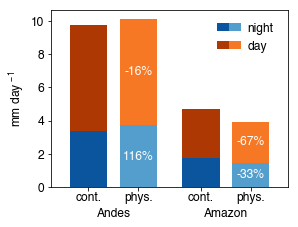

In [60]:
fontsize = 12
fig = mp.figure(figsize=(4.25,3.25))

ax = fig.add_subplot(111)
ax.tick_params(labelsize=fontsize)

loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .75

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and*24.,bottom=raintot_diffs_400_PMtoAM_and*24.,fc=orange_cmap[-1],width=barwidth)

ax.bar(loc2,raintot_diffs_1000_PMtoAM_and*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and*24.,bottom=raintot_diffs_1000_PMtoAM_and*24.,fc=orange_cmap[-3],width=barwidth)

ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])

ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)

ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)

ax.set_yticks([0,2,4,6,8,10])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)

ax.text(s='cont.',x=loc1,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='phys.',x=loc2,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='cont.',x=loc3,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='phys.',x=loc4,y=-.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1.25,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1.25,fontsize=fontsize,ha='center',va='top')


# andes night
fraction = and_PMtoAM_diff/and_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_and*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')
# andes day
fraction = and_AMtoPM_diff/and_total_diff
y0 = raintot_diffs_1000_PMtoAM_and*24
y1 = (raintot_diffs_1000_PMtoAM_and+raintot_diffs_1000_AMtoPM_and)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')


# amazon night
fraction = -ama_PMtoAM_diff/ama_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')
# amazon day
fraction = -ama_AMtoPM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = (raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='1')


handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))

labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

# big panel plot

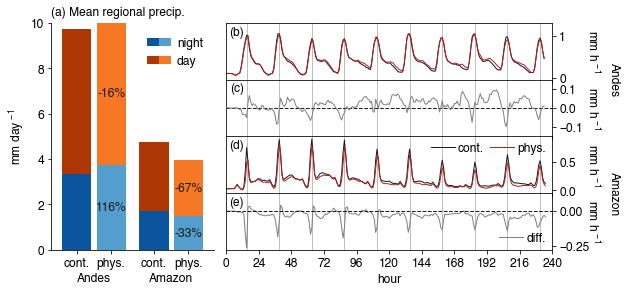

In [72]:
fontsize = 12

fig = mp.figure(figsize=(8.5,4))

gs = matplotlib.gridspec.GridSpec(4,2,width_ratios=[1,2])


ax1 = fig.add_subplot(gs[0,1])
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_400_latlon_mean_and,\
       color='0.1',lw=1,label='cont.')
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, raintot_diffs_1000_latlon_mean_and,\
       color='firebrick',lw=1,label='phys.')
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax1.yaxis.set_label_coords(1.1,0.5)
ax1.yaxis.tick_right()
ax1.set_xticks(numpy.arange(0,241,24))
ax1.set_xlim(0,240)
handles, labels = ax1.get_legend_handles_labels()
ax1.set_xticks(numpy.arange(15,241,24), minor=True)
ax1.xaxis.grid(which='minor')
ax1.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
#ax1.set_ylim(-.2,ax1.get_ylim()[1])
ax1.set_ylim(ax1.get_ylim()[0],1.3)


ax2 = fig.add_subplot(gs[1,1], sharex=ax1)
ax2.plot(numpy.arange(raintot_diffs_400_latlon_mean_and.size)-5, (raintot_diffs_1000_latlon_mean_and-raintot_diffs_400_latlon_mean_and),\
       color='0.5',lw=1,label='diff.',zorder=3)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax2.yaxis.set_label_coords(1.1,0.5)
ax2.yaxis.tick_right()
ax2.set_xticks(numpy.arange(0,241,24))
#ax2.set_yticks([-.05,0,.05])
ax2.set_xlim(0,240)
ax2.axhline(0, lw=1, ls='--', c='0.1')
ax2.set_xticks(numpy.arange(18,241,24), minor=True)
ax2.xaxis.grid(which='minor')
ax2.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax2.set_ylim(-.15,.15)

ax3 = fig.add_subplot(gs[2,1], sharex=ax1)
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=1,label='cont.')
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
       color='firebrick',lw=1,label='phys.')
ax3.tick_params(labelsize=fontsize)
ax3.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax3.yaxis.set_label_coords(1.1,0.5)
ax3.yaxis.tick_right()
ax3.set_xticks(numpy.arange(0,241,24))
ax3.set_xlim(0,240)
ax3.xaxis.grid(which='minor')
ax3.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=2, bbox_to_anchor=(.99,.95), bbox_transform=ax3.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax3.set_xticks(numpy.arange(15,241,24), minor=True)



ax4 = fig.add_subplot(gs[3,1], sharex=ax1)
ax4.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, (raintot_diffs_1000_latlon_mean_ama-raintot_diffs_400_latlon_mean_ama),\
       color='0.5',lw=1,label='diff.')
ax4.tick_params(labelsize=fontsize)
ax4.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax4.yaxis.set_label_coords(1.1,0.5)
ax4.yaxis.tick_right()
ax4.set_xticks(numpy.arange(0,241,24))
ax4.set_xlim(0,240)
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.05), bbox_transform=ax4.transAxes, \
          loc='lower right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax4.set_xticks(numpy.arange(15,241,24), minor=True)
ax4.xaxis.grid(which='minor')
ax4.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax4.axhline(0, lw=1, ls='--', c='0.1')
ax4.set_ylim(ax4.get_ylim()[0],0.13)
ax4.set_xlabel('hour', fontsize=fontsize)
#ax4.set_xticklabels(ax4.get_xticks())

################################################################################
################################################################################
ax = fig.add_subplot(gs[:,0])
ax.tick_params(labelsize=fontsize)
loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .85

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and*24.,bottom=raintot_diffs_400_PMtoAM_and*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_PMtoAM_and*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and*24.,bottom=raintot_diffs_1000_PMtoAM_and*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])
ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_yticks([0,2,4,6,8,10])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,10)

ax.set_xticklabels(['cont.','phys.','cont.','phys.'])
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1,fontsize=fontsize,ha='center',va='top')
# andes night
fraction = and_PMtoAM_diff/and_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_and*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# andes day
fraction = and_AMtoPM_diff/and_total_diff
y0 = raintot_diffs_1000_PMtoAM_and*24
y1 = (raintot_diffs_1000_PMtoAM_and+raintot_diffs_1000_AMtoPM_and)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc2,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon night
fraction = -ama_PMtoAM_diff/ama_total_diff
y0 = 0
y1 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon day
fraction = -ama_AMtoPM_diff/ama_total_diff
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = (raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)*24
ax.text(s='{:.0f}'.format(fraction*100.)+'%',x=loc4,y=0.5*(y0+y1),ha='center',va='center',fontsize=fontsize,color='0.1')

handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))
labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

mp.setp(ax1.get_xticklabels(), visible=False)
mp.setp(ax2.get_xticklabels(), visible=False)
mp.setp(ax3.get_xticklabels(), visible=False)

fig.tight_layout()
gs.update(hspace=0.,wspace=0.05)

ax1.text(s='Andes', x=285, y=ax1.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)

ax3.text(s='Amazon', x=285, y=ax3.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)


ax.text(s='(a) Mean regional precip.', x=0, y=1.02, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes)
ax1.text(s='(b)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(c)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(d)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax3.transAxes)
ax4.text(s='(e)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax4.transAxes)

fig.savefig('precip_change_and_percentages_daynight.png', dpi=600, bbox_inches='tight', transparent=True)



# also do for precip over mountainous areas ONLY

In [62]:
mp.rcParams.update({'mathtext.default': 'regular'})

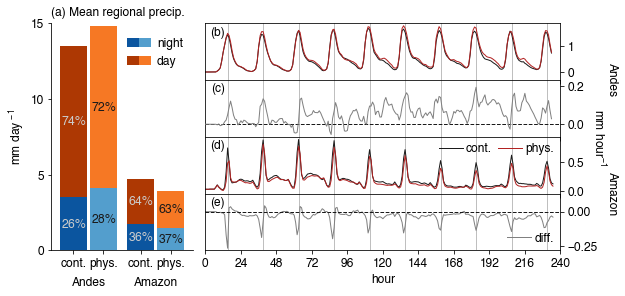

In [82]:
fontsize = 12

fig = mp.figure(figsize=(8.5,4))

gs = matplotlib.gridspec.GridSpec(4,2,width_ratios=[1,2.5])


ax1 = fig.add_subplot(gs[0,1])
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, raintot_diffs_400_latlon_mean_and_high,\
       color='0.1',lw=1,label='cont.')
ax1.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, raintot_diffs_1000_latlon_mean_and_high,\
       color='firebrick',lw=1,label='phys.')
ax1.tick_params(labelsize=fontsize)
# ax1.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax1.yaxis.set_label_coords(1.1,0.5)
ax1.yaxis.tick_right()
ax1.set_xticks(numpy.arange(0,241,24))
ax1.set_xlim(0,240)
handles, labels = ax1.get_legend_handles_labels()
ax1.set_xticks(numpy.arange(15,241,24), minor=True)
ax1.xaxis.grid(which='minor')
ax1.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax1.set_ylim(-.3,ax1.get_ylim()[1])
#ax1.set_ylim(-.5,ax1.get_ylim()[1])


ax2 = fig.add_subplot(gs[1,1], sharex=ax1)
ax2.plot(numpy.arange(raintot_diffs_400_latlon_mean_and_high.size)-5, (raintot_diffs_1000_latlon_mean_and_high-raintot_diffs_400_latlon_mean_and_high),\
       color='0.5',lw=1,label='diff.',zorder=3)
ax2.tick_params(labelsize=fontsize)
# ax2.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax2.yaxis.set_label_coords(1.1,0.5)
ax2.yaxis.tick_right()
ax2.set_xticks(numpy.arange(0,241,24))
#ax2.set_yticks([-.05,0,.05])
ax2.set_xlim(0,240)
ax2.axhline(0, lw=1, ls='--', c='0.1')
ax2.set_xticks(numpy.arange(18,241,24), minor=True)
ax2.xaxis.grid(which='minor')
ax2.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax2.set_ylim(ax2.get_ylim()[0],.23)

ax3 = fig.add_subplot(gs[2,1], sharex=ax1)
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_400_latlon_mean_ama,\
       color='0.1',lw=1,label='cont.')
ax3.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, raintot_diffs_1000_latlon_mean_ama,\
       color='firebrick',lw=1,label='phys.')
ax3.tick_params(labelsize=fontsize)
# ax3.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax3.yaxis.set_label_coords(1.1,0.5)
ax3.yaxis.tick_right()
ax3.set_xticks(numpy.arange(0,241,24))
ax3.set_xlim(0,240)
ax3.xaxis.grid(which='minor')
ax3.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=2, bbox_to_anchor=(.99,.95), bbox_transform=ax3.transAxes, \
          loc='upper right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax3.set_xticks(numpy.arange(15,241,24), minor=True)



ax4 = fig.add_subplot(gs[3,1], sharex=ax1)
ax4.plot(numpy.arange(raintot_diffs_400_latlon_mean_ama.size)-4, (raintot_diffs_1000_latlon_mean_ama-raintot_diffs_400_latlon_mean_ama),\
       color='0.5',lw=1,label='diff.')
ax4.tick_params(labelsize=fontsize)
# ax4.set_ylabel('mm h$^{\,-1}$', fontsize=fontsize, rotation=-90)
ax4.yaxis.set_label_coords(1.1,0.5)
ax4.yaxis.tick_right()
ax4.set_xticks(numpy.arange(0,241,24))
ax4.set_xlim(0,240)
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
          ncol=1, bbox_to_anchor=(.99,.05), bbox_transform=ax4.transAxes, \
          loc='lower right', borderaxespad=0, labelspacing=0.25, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, columnspacing=0.5, \
          handletextpad=0.25, markerscale=1)
ax4.set_xticks(numpy.arange(15,241,24), minor=True)
ax4.xaxis.grid(which='minor')
ax4.tick_params(axis='x',which='minor',bottom=False,labelbottom=False)
ax4.axhline(0, lw=1, ls='--', c='0.1')
ax4.set_ylim(ax4.get_ylim()[0],0.13)
ax4.set_xlabel('hour', fontsize=fontsize)
#ax4.set_xticklabels(ax4.get_xticks())

################################################################################
################################################################################

ax = fig.add_subplot(gs[:,0])
ax.tick_params(labelsize=fontsize)
loc1=1
loc2=2
loc3=3.25
loc4=4.25
barwidth = .9

ax.set_xlim(loc1-.75,loc4+.75)
ax.bar(loc1,raintot_diffs_400_PMtoAM_and_high*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc1,raintot_diffs_400_AMtoPM_and_high*24.,bottom=raintot_diffs_400_PMtoAM_and_high*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_PMtoAM_and_high*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc2,raintot_diffs_1000_AMtoPM_and_high*24.,bottom=raintot_diffs_1000_PMtoAM_and_high*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_xticklabels([])
ax.set_xticks([loc1,loc2,loc3,loc4])
ax.bar(loc3,raintot_diffs_400_PMtoAM_ama*24.,fc=blue_cmap[-1],width=barwidth)
ax.bar(loc3,raintot_diffs_400_AMtoPM_ama*24.,bottom=raintot_diffs_400_PMtoAM_ama*24.,fc=orange_cmap[-1],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_PMtoAM_ama*24.,fc=blue_cmap[-3],width=barwidth)
ax.bar(loc4,raintot_diffs_1000_AMtoPM_ama*24.,bottom=raintot_diffs_1000_PMtoAM_ama*24.,fc=orange_cmap[-3],width=barwidth)
ax.set_yticks([0,5,10,15])
ax.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,15)

ax.set_xticklabels(['cont.','phys.','cont.','phys.'])
ax.text(s='Andes',x=.5*(loc1+loc2),y=-1.75,fontsize=fontsize,ha='center',va='top')
ax.text(s='Amazon',x=.5*(loc3+loc4),y=-1.75,fontsize=fontsize,ha='center',va='top')
# PHYS RESPONSE
# andes night
fraction = raintot_diffs_1000_PMtoAM_and_high/(raintot_diffs_1000_AMtoPM_and_high+raintot_diffs_1000_PMtoAM_and_high)
y0 = raintot_diffs_1000_PMtoAM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc2,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.1')
# andes day
fraction = raintot_diffs_1000_AMtoPM_and_high/(raintot_diffs_1000_AMtoPM_and_high+raintot_diffs_1000_PMtoAM_and_high)
y0 = raintot_diffs_1000_PMtoAM_and_high*24
y1 = raintot_diffs_1000_AMtoPM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc2,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon night
fraction = raintot_diffs_1000_PMtoAM_ama/(raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)
y0 = raintot_diffs_1000_PMtoAM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc4,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.1')
# amazon day
fraction = raintot_diffs_1000_AMtoPM_ama/(raintot_diffs_1000_AMtoPM_ama+raintot_diffs_1000_PMtoAM_ama)
y0 = raintot_diffs_1000_PMtoAM_ama*24
y1 = raintot_diffs_1000_AMtoPM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc4,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.1')

# CONTROL
# andes night
fraction = raintot_diffs_400_PMtoAM_and_high/(raintot_diffs_400_AMtoPM_and_high+raintot_diffs_400_PMtoAM_and_high)
y0 = raintot_diffs_400_PMtoAM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc1,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.8')
# andes day
fraction = raintot_diffs_400_AMtoPM_and_high/(raintot_diffs_400_AMtoPM_and_high+raintot_diffs_400_PMtoAM_and_high)
y0 = raintot_diffs_400_PMtoAM_and_high*24
y1 = raintot_diffs_400_AMtoPM_and_high*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc1,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.8')
# amazon night
fraction = raintot_diffs_400_PMtoAM_ama/(raintot_diffs_400_AMtoPM_ama+raintot_diffs_400_PMtoAM_ama)
y0 = raintot_diffs_400_PMtoAM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc3,y=0.5*y0,ha='center',va='center',fontsize=fontsize,color='0.8')
# amazon day
fraction = raintot_diffs_400_AMtoPM_ama/(raintot_diffs_400_AMtoPM_ama+raintot_diffs_400_PMtoAM_ama)
y0 = raintot_diffs_400_PMtoAM_ama*24
y1 = raintot_diffs_400_AMtoPM_ama*24
ax.text(s='${:.0f}$'.format(fraction*100.)+'%',x=loc3,y=y0+0.5*y1,ha='center',va='center',fontsize=fontsize,color='0.8')

# fraction for change
# fraction = and_high_total_diff/raintot_diffs_400_timemean_and_high
# y0 = raintot_diffs_400_PMtoAM_and_high*24
# ax.text(s='${:.0f}$'.format(fraction*100.)+'%\ninc.',x=loc1,y=y0,ha='center',va='center',fontsize=fontsize,color='.9')

# fraction = -ama_total_diff/raintot_diffs_400_timemean_ama
# y0 = raintot_diffs_400_PMtoAM_ama*24
# ax.text(s='${:.0f}$'.format(fraction*100.)+'%\ndec.',x=loc3,y=y0,ha='center',va='center',fontsize=fontsize,color='.9')

handles = [mp.Rectangle((0,0),1,1) for i  in range(2)]
colors = [[blue_cmap[-1],blue_cmap[-3]],[orange_cmap[-1],orange_cmap[-3]]]
hmap = dict(zip(handles, [Handler(color_list[0],color_list[1]) for color_list in colors] ))
labels = ['night', 'day']
ax.legend(handles=handles, labels=labels, handler_map=hmap, fontsize=fontsize,\
          loc='upper right', bbox_to_anchor=(.95,.95), borderaxespad=0, labelspacing=0.5, fancybox=False, \
          edgecolor='0', framealpha=0, borderpad=0.25, handletextpad=0.5)

mp.setp(ax1.get_xticklabels(), visible=False)
mp.setp(ax2.get_xticklabels(), visible=False)
mp.setp(ax3.get_xticklabels(), visible=False)

#================================================================================
fig.tight_layout()

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
fig.text(s='mm hour$^{-1}$', x=ax1pos.x1+0.05, y=ax4pos.y0+(ax1pos.y1-ax4pos.y0)*0.5,\
         fontsize=fontsize, rotation=-90, transform=fig.transFigure, va='center', ha='left')

gs.update(hspace=0.,wspace=0.05)

ax1.text(s='Andes', x=275, y=ax1.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)

ax3.text(s='Amazon', x=275, y=ax3.get_ylim()[0],\
        ha='center',va='center',rotation=-90, fontsize=fontsize)


ax.text(s='(a) Mean regional precip.', x=0, y=1.02, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes)
ax1.text(s='(b)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(s='(c)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax2.transAxes)
ax3.text(s='(d)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax3.transAxes)
ax4.text(s='(e)', x=0.055, y=0.95, ha='right', va='top', fontsize=fontsize, transform=ax4.transAxes)

fig.savefig('figures/precip_change_and_high_percentages_daynight_high_andes_figure_4.png', dpi=600, bbox_inches='tight', transparent=True)

